# APS1052 Final Project - LSTM Bitcoin

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
The data set is already downloaded for us from the Glassnode

In [40]:
# Load the dataset
file_path = "data/btc_dataset.csv"  # Replace with your dataset path
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Preview the data
df.head()


,Closing Price (USD),active_addresses,hash_rate,btc_left,total_addresses,difficulty,total_fees,fed_assets,GLD,IYE,SLV,SPY,TLT,UUP,NYFed_inflation,Google_popularity
Date,,,,,,,,,,,,,,,,
2013-10-01,123.65499,89218,1309351515956620,9220600.0,18656301,639173596179762000,39.139746,3.747387e+06,124.589996,47.430000,20.41,169.339996,105.800003,21.610001,1.738484,3
2013-10-02,125.45500,105303,1307159450402430,9215825.0,18708039,639173596179762000,39.923033,3.747387e+06,127.059998,47.540001,20.92,169.179993,105.959999,21.530001,1.738484,3
2013-10-03,108.58483,89993,1452700445873280,9210850.0,18751619,639173596179762000,36.602946,3.748998e+06,127.180000,47.099998,20.92,167.619995,105.790001,21.510000,1.738484,3
2013-10-04,118.67466,77370,1283409529949880,9206350.0,18791964,639173596179762000,24.772795,3.750609e+06,126.529999,47.520000,20.93,168.889999,105.709999,21.610001,1.738484,3
2013-10-05,121.33866,64961,1602048841926960,9200875.0,18823649,639173596179762000,26.062425,3.752220e+06,126.529999,47.520000,20.93,168.889999,105.709999,21.610001,1.738484,3


Check if there is any missing value.

In [41]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Display the result
if missing_columns.empty:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:")
    print(missing_columns)

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    missing_columns.plot(kind='bar', title="Count of Missing Values by Column")
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.show()


No missing values in the dataset.


# Loading Data

## Feature Engineering

### 1. Realized Volatility (14-day Rolling)
- **How to Derive**: Compute the rolling standard deviation of the "Closing Price (USD)" log returns over the past 14 days.
- **Implementation**:
    $$
    \text{Realized Volatility} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\log(P_t/P_{t-1}))^2}
    $$
- **Relevant Columns**: `"Closing Price (USD)"`

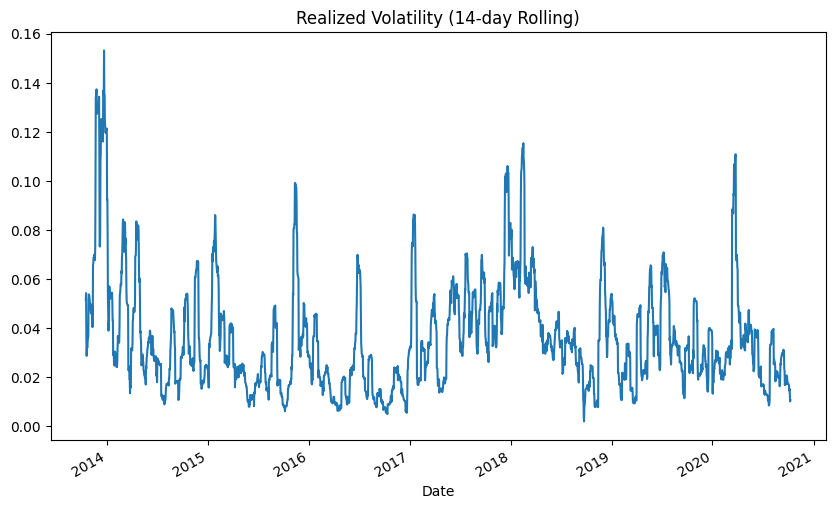

In [42]:
# Calculate log returns
df['log_return'] = np.log(df['Closing Price (USD)'] / df['Closing Price (USD)'].shift(1))

# Calculate realized volatility (14-day rolling standard deviation)
df['realized_volatility'] = df['log_return'].rolling(window=14).std()

# Drop the temporary column
df.drop(columns=['log_return'], inplace=True)

# Visualize the feature
plt.figure(figsize=(10, 6))
df['realized_volatility'].plot(title="Realized Volatility (14-day Rolling)")
plt.show()


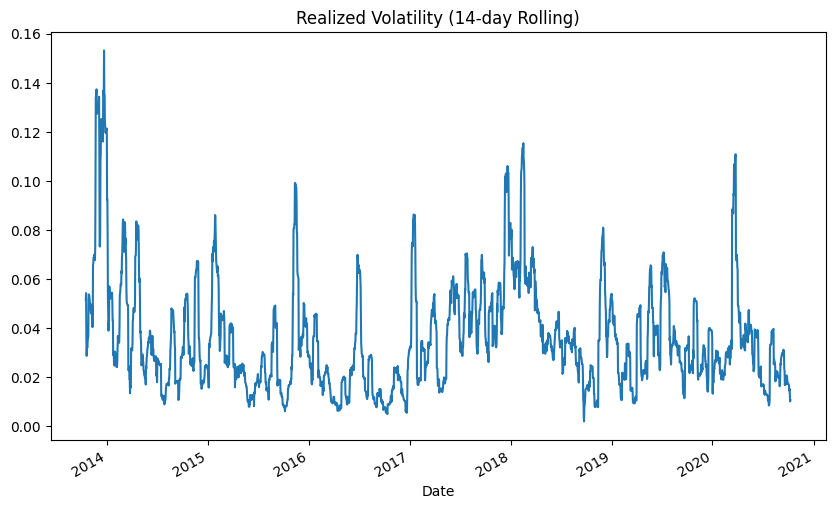

In [43]:
# Calculate log returns
df['log_return'] = np.log(df['Closing Price (USD)'] / df['Closing Price (USD)'].shift(1))

# Calculate realized volatility (14-day rolling standard deviation)
df['realized_volatility'] = df['log_return'].rolling(window=14).std()

# Drop the temporary column
df.drop(columns=['log_return'], inplace=True)

# Visualize the feature
plt.figure(figsize=(10, 6))
df['realized_volatility'].plot(title="Realized Volatility (14-day Rolling)")
plt.show()


#### 2. Exchange Netflow Proxy
- **How to Derive**: Use `"active_addresses"` as a proxy for activity. Calculate the daily change in `"active_addresses"` or the ratio of `"active_addresses"` to `"total_addresses"`. This can act as a proxy for inflow/outflow activity.
- **Implementation**:
$$
     \text{Netflow Proxy} = \frac{\text{active\_addresses}}{\text{total\_addresses}}
     $$
- **Relevant Columns**: `"active_addresses"`, `"total_addresses"`


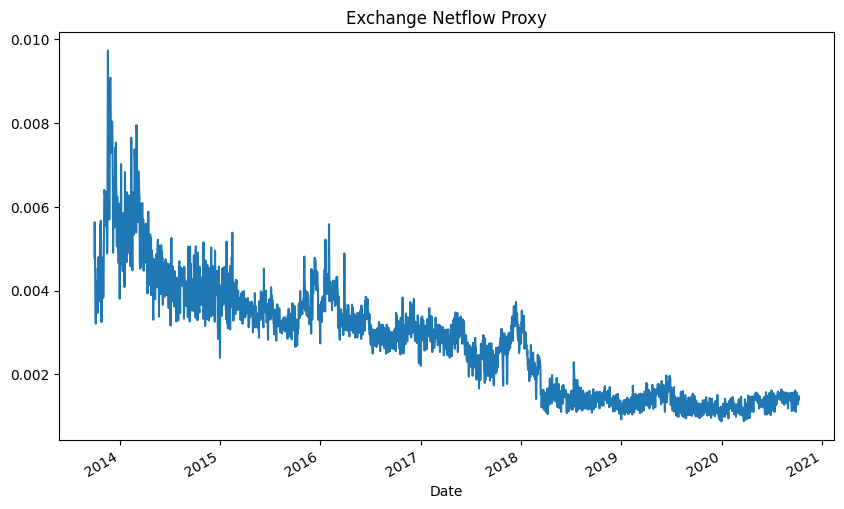

In [44]:
# Ratio of active addresses to total addresses as a proxy for netflow
df['exchange_netflow_proxy'] = df['active_addresses'] / df['total_addresses']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['exchange_netflow_proxy'].plot(title="Exchange Netflow Proxy")
plt.show()


### 3. Social Sentiment Proxy (Google Popularity Change)
- **How to Derive**: Use the percentage change or rolling average of `"Google_popularity"` to capture shifts in public interest over time.
- **Implementation**:
     $$
     \text{Google Sentiment} = \frac{\text{Google\_popularity}_t - \text{Google\_popularity}_{t-1}}{\text{Google\_popularity}_{t-1}}
     $$
- **Relevant Columns**: `"Google_popularity"`

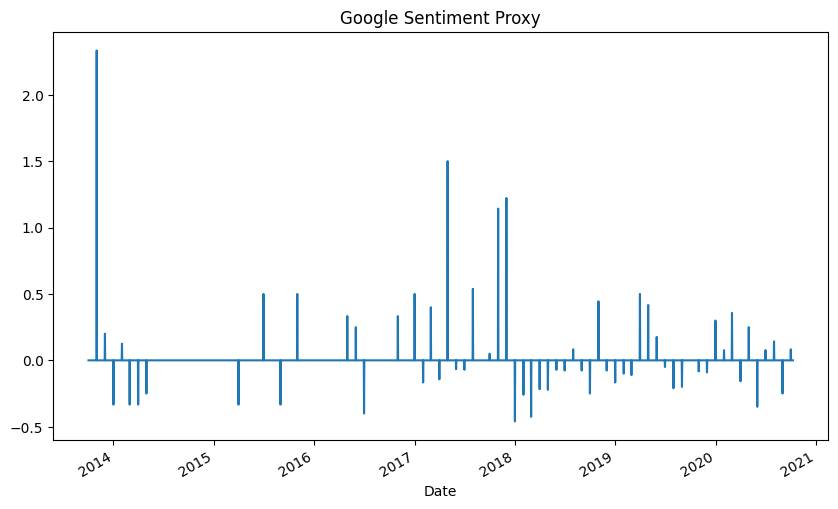

In [45]:
# Percentage change in Google Popularity
df['google_sentiment_proxy'] = df['Google_popularity'].pct_change()

# Visualize the feature
plt.figure(figsize=(10, 6))
df['google_sentiment_proxy'].plot(title="Google Sentiment Proxy")
plt.show()


### 4. Funding Rates Proxy (Mining Cost Ratio)
   - **How to Derive**: Calculate the ratio of `"hash_rate"` to `"difficulty"`, which can act as a proxy for mining costs and potential supply-side pressures.
   - **Implementation**:
     $$
     \text{Mining Cost Ratio} = \frac{\text{hash\_rate}}{\text{difficulty}}
     $$
   - **Relevant Columns**: `"hash_rate"`, `"difficulty"`


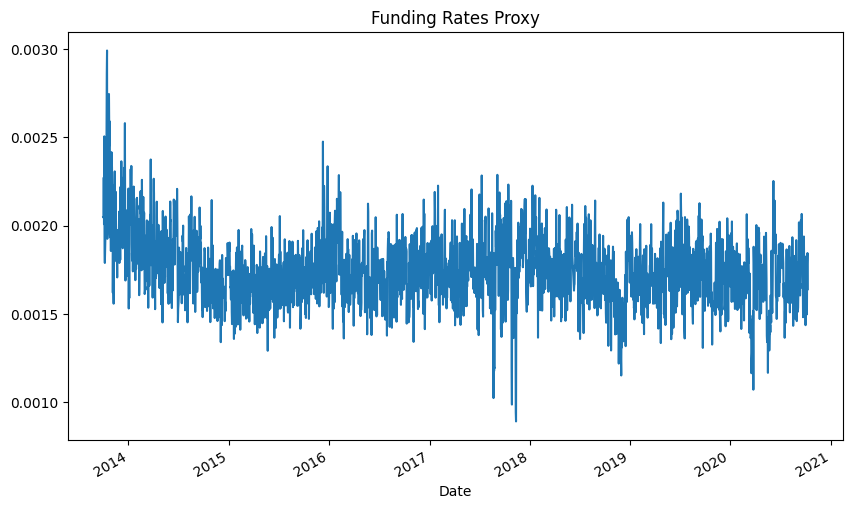

In [46]:
# Convert columns to numeric
df['hash_rate'] = pd.to_numeric(df['hash_rate'], errors='coerce')
df['difficulty'] = pd.to_numeric(df['difficulty'], errors='coerce')

# Mining cost ratio as a proxy for funding rates
df['funding_rate_proxy'] = df['hash_rate'] / df['difficulty']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['funding_rate_proxy'].plot(title="Funding Rates Proxy")
plt.show()


### 5. Macro Interaction Proxy (GLD-SPY Interaction)
   - **How to Derive**: Create interaction terms between `"GLD"` (gold prices) and `"SPY"` (S&P 500 index) to capture broader macroeconomic influences. This could be the product or difference between the two.
   - **Implementation**:
     $$
     \text{GLD-SPY Interaction} = \text{GLD} \times \text{SPY}
     $$
   - **Relevant Columns**: `"GLD"`, `"SPY"`

Check if there is any missing value.

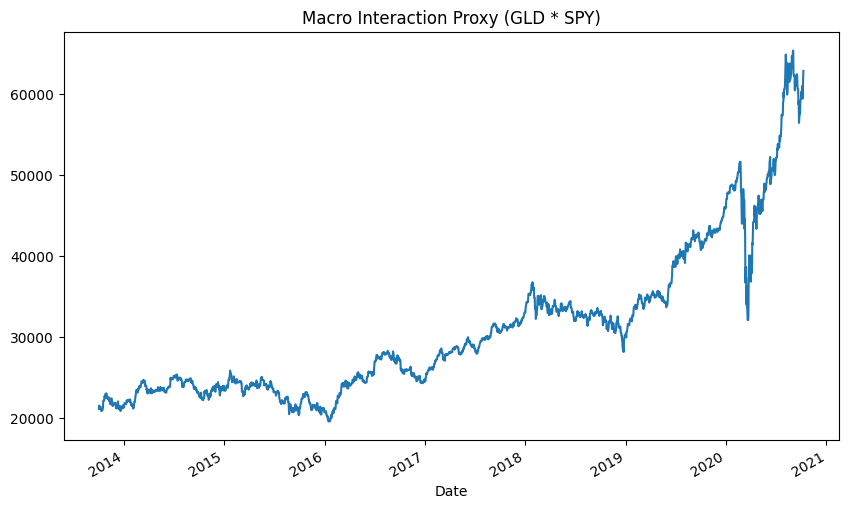

In [47]:
# Interaction between GLD and SPY
df['macro_interaction_proxy'] = df['GLD'] * df['SPY']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['macro_interaction_proxy'].plot(title="Macro Interaction Proxy (GLD * SPY)")
plt.show()


Missing values in each column:
realized_volatility       14
google_sentiment_proxy     1
dtype: int64


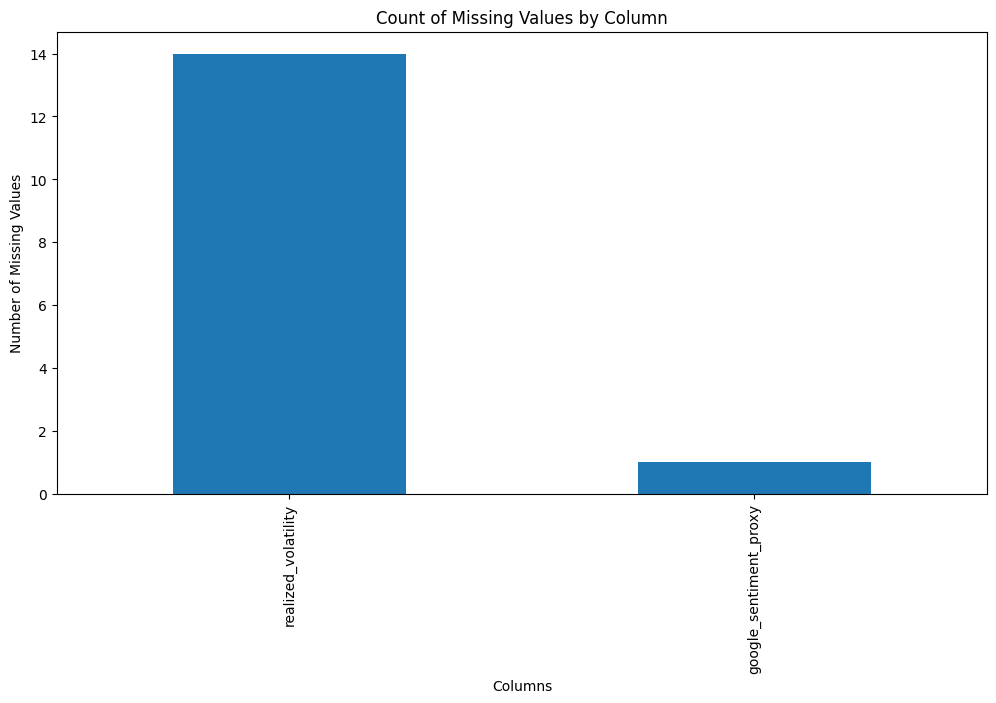

In [48]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Display the result
if missing_columns.empty:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:")
    print(missing_columns)

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    missing_columns.plot(kind='bar', title="Count of Missing Values by Column")
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.show()


This caused by the way we calculate the two features.
We have two different options:
1. `NaN`
2. `0`

Which Option to Choose?
- **For Long-Term Models or Sparse Data:** Use **Option 1** (`NaN`) and drop rows with missing values. This maintains the integrity of the calculations.
- **For Time Series Models with Long Sequences:** Use **Option 2** (fill with `0`) to avoid breaking sequence continuity.

Since we are working with LSTMs and sequences, Option 2 (setting to `0`) is more practical:
- It avoids disrupting sequences, which is critical for time series models.
- The missing data period (**14** days for volatility, **1** day for sentiment) is short, so the impact of filling with `0` is minimal.


In [49]:
df['realized_volatility'] = df['realized_volatility'].fillna(0)
df['google_sentiment_proxy'] = df['google_sentiment_proxy'].fillna(0)

### Feature Drop
Features with sparse and infrequent activity may not significantly contribute to the model's predictions. As most values in `df['google_sentiment_proxy']` is zero, we decided to drop it.

In [50]:
# Drop the Google Sentiment Proxy column from the dataset
df.drop(columns=['google_sentiment_proxy'], inplace=True)

In [51]:
# Save the current DataFrame to a CSV file
file_path = "data/BTC_data.csv"
df.to_csv(file_path, index=True)

## Dataset Preparation

### Dataset Split

In [52]:
# Define split ratios
train_ratio = 0.64  # 64% for training (80% of Train + Validation)
validation_ratio = 0.16  # 16% for validation (20% of Train + Validation)
test_ratio = 0.20  # 20% for testing

# Calculate indices for splits
train_end_index = int(len(df) * train_ratio)
validation_end_index = int(len(df) * (train_ratio + validation_ratio))

# Sequential split
train_data = df.iloc[:train_end_index]
validation_data = df.iloc[train_end_index:validation_end_index]
test_data = df.iloc[validation_end_index:]

# Print the shapes
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Testing data shape: {test_data.shape}")


Training data shape: (1635, 20)
Validation data shape: (409, 20)
Testing data shape: (512, 20)


### Data Normalization

**Why Normalize Data for Bitcoin Price Prediction?**
Normalization is a crucial preprocessing step for time series forecasting tasks, especially for Bitcoin price prediction, because:

1. **Stabilizing the Scale**:
   - Bitcoin price and other features (e.g., hash rate, difficulty, or macroeconomic factors) can have vastly different scales.
   - Normalizing the data ensures all features are on a similar scale, making it easier for the LSTM to learn patterns.

2. **Improving Model Training**:
   - Models like LSTMs are sensitive to the magnitude of input values. If the input features are not normalized, the gradient updates during training can become unstable.
   - Normalized data ensures smoother gradients and faster convergence.

3. **Relative Changes Over Absolute Values**:
   - For financial data like Bitcoin prices, the relative change in values (e.g., percent change) is often more important than absolute values.
   - By normalizing sequences relative to their starting value (e.g., the first value in each sequence), we emphasize the relative dynamics within the window.

4. **Simplifying Interpretation**:
   - Normalizing data to start at a baseline of 0 makes it easier to interpret the model's output relative to the starting point of the sequence.

**Formula for Normalization:**
The data is normalized using the first value in each sequence as the baseline:
$$
\text{Normalized Value} = \left(\frac{\text{Value}}{\text{First Value}} \right) - 1
$$
This ensures each sequence starts at a normalized value of 0.

---

**Why Use a Window for BTC Forecasting?**
The **lookback window** defines how many past days' data the model considers when making predictions. This choice is important for time series forecasting because:

1. **Capturing Temporal Patterns**:
   - Bitcoin prices and on-chain metrics (e.g., hash rate, active addresses) exhibit temporal dependencies. Using a window allows the model to identify these patterns, such as trends and cycles.

2. **Avoiding Overfitting**:
   - A window that’s too large includes excessive noise and irrelevant data, leading to overfitting.
   - A smaller window focuses on more recent, relevant data, improving model generalization.

3. **Balancing Short-Term and Long-Term Trends**:
   - Bitcoin prices are influenced by both short-term (e.g., market sentiment) and long-term trends (e.g., macroeconomic conditions). The window length determines the balance between these two.

4. **Practicality for Financial Decisions**:
   - In practical trading scenarios, decisions often rely on recent data rather than a full historical analysis. A well-chosen window ensures the model’s output aligns with real-world decision-making.

**Typical Window Setting for BTC:**
- For daily data, a **21-day window** (3 weeks) is commonly used:
  - Captures short-term trends effectively.
  - Includes enough data to detect meaningful patterns without introducing excessive noise.



In [53]:
# Define the lookback window
lookback_window = 21  # Use the past 21 days to predict the target

# Columns with leading zeros
leading_zeros = ['realized_volatility']


In [54]:
# Function to normalize sequences for training (with leading zero handling)
def normalize_sequences_train(data, columns_with_leading_zeros):
    normalized_data = []
    for i in range(len(data) - lookback_window):
        sequence = data.iloc[i:i + lookback_window].copy()  # Copy the sequence
        base = sequence.iloc[0].copy()  # Explicitly copy the first row as baseline

        # For problematic columns, find the first non-zero value
        for col in columns_with_leading_zeros:
            non_zero_index = sequence[col].ne(0).idxmax()  # Find the index of the first non-zero value
            if pd.notnull(non_zero_index):  # Ensure the index exists
                base[col] = sequence.loc[non_zero_index, col]  # Set the first non-zero value as the baseline

        # Normalize the sequence
        normalized_sequence = (sequence / base) - 1
        normalized_data.append(normalized_sequence.values)

    return np.array(normalized_data)

# Function to normalize sequences for validation and test (no leading zero handling needed)
def normalize_sequences(data):
    normalized_data = []
    for i in range(len(data) - lookback_window):
        sequence = data.iloc[i:i + lookback_window].copy()
        base = sequence.iloc[0].copy()
        normalized_sequence = (sequence / base) - 1
        normalized_data.append(normalized_sequence.values)

    return np.array(normalized_data)

# Normalize training data with leading zero handling
x_train = normalize_sequences_train(train_data, leading_zeros)

# Normalize validation and test data without leading zero handling
x_validation = normalize_sequences(validation_data)
x_test = normalize_sequences(test_data)

# Print the shapes of normalized data
print(f"Normalized training data shape: {x_train.shape}")
print(f"Normalized validation data shape: {x_validation.shape}")
print(f"Normalized testing data shape: {x_test.shape}")


Normalized training data shape: (1614, 21, 20)
Normalized validation data shape: (388, 21, 20)
Normalized testing data shape: (491, 21, 20)


Check any `NaN`, `inf` or Anomalous Values in the normalized dataset

In [55]:
# Function to validate normalized data
def validate_normalized_data(normalized_data):
    # Check for NaN values
    nan_count = np.isnan(normalized_data).sum()
    if nan_count > 0:
        print(f"Warning: Found {nan_count} NaN values in the normalized data.")
        normalized_data[np.isnan(normalized_data)] = 0  # Replace NaN with 0

    # Check for Inf values
    inf_count = np.isinf(normalized_data).sum()
    if inf_count > 0:
        print(f"Warning: Found {inf_count} Inf values in the normalized data.")
        normalized_data[np.isinf(normalized_data)] = 0  # Replace Inf with 0

    # Check for negative or unexpected values (optional, based on your use case)
    if (normalized_data < -1).sum() > 0:
        print("Warning: Found values less than -1. Review the normalization process.")

    print("Validation complete. Normalized data is clean.")
    return normalized_data


In [56]:
# Validate the normalized datasets
x_train = validate_normalized_data(x_train)
x_validation = validate_normalized_data(x_validation)
x_test = validate_normalized_data(x_test)


Validation complete. Normalized data is clean.
Validation complete. Normalized data is clean.
Validation complete. Normalized data is clean.


# LSTM Model

## Model Implementation